In [1]:
%matplotlib inline
import json,requests
import numpy as np
import pandas as pd
import hashlib
import matplotlib.pyplot as plt
import re
from itertools import compress
import os
import csv
from readDBF import getAreaDict as readArea
import subprocess
import base64
from cryptography.fernet import Fernet
import ast
import getpass

#Interacting with data.met.no using their web API
#Getting credentials token  #This should be made private
credentials = bytes('gAAAAABaBG5P2tZrbQdYrW_47s4XFCNt29iSXg_BO2-acCOz--uCGVKoG78UGE5gZnpMexVTvlzbG9oa0kywsEQdb_4Qj_QqSAXPNoGKfb7_JXj0iTW_x5mYHJI8akU0vSLmy51NN59T89cnVBtzeQpCJhZ9VygmvbaJTg3fBJXjIAmzrYZKovQkWrSAM-DpzvhOtYpCsoOl_9EMwPCozYXx5-gt-BGQ35KsqswpVhJQ5GYQPngbF_pTxUDvMZl0YtR2tF300rKMWKUSQBtmMyHGADtNdt_R5g==','utf-8')
key = getpass.getpass('Password: ')
key = key.zfill(32)
key=base64.b64encode(bytes(key,'utf-8'))
cipher_suite=Fernet(key)
data = ast.literal_eval(cipher_suite.decrypt(credentials).decode('utf-8'))

query = requests.post('https://data.met.no/auth/requestAccessToken', data=data)
data = json.loads(query.text)

Password: ········


# HBV modelling at Storelva and Alna

This document describes the setup of the HBV hydrological model for the Storelva and Alna basins for the Elveøvervåkning project.

## Data

### DEM

Freely available [SRTM](https://www2.jpl.nasa.gov/srtm/cbanddataproducts.html) (Shuttle Radar Topgraphy Mission) downloaded through [Earth Explorer](https://earthexplorer.usgs.gov/). The DEM (Digital Elevation Model) has a resolution of 1 arcsecond (around 30m, depending on lat/long).

### Discharge
NVE discharge data from the Hydra II database was used. Øyvind and James provided the data. 

### Meteo data

Meteorological data provided by the [Meteorologisk Institut](https://www.met.no/) was downloaded from data.met.no using their web API.

The relevant stations were identified through the following sequential procedure:

1. Using the DEM and outlet coordinates, define the basin boundaries using the [TauDEM](http://hydrology.usu.edu/taudem/taudem5/index.html) package for [QGIS](http://www.qgis.org/en/site/)
1. Once the basin boundaries are found, apply a buffer of 20km to define a new polygon
1. Simplify this polygon to contain less nodes. 
1. The stations falling inside the simplified polygon are found using the [data.met.no API](https://data.met.no/concepts#getting_started). The polygon was simplified because the API does not allow complex (read: with many nodes) polygons.
1. After finding the stations inside the simplified polygon the data.met.no API is used to obtain the data.

#### Storelva:

**Polygon within which data will be downloaded:**

In [2]:
#Getting the stations inside polygon
bufferPolygon = {"geometry" : "POLYGON ((8.81360824104544 58.3869720294933,8.8125028700531 58.3869720294933,\
                                         8.6791677645676 58.3953610184671,8.60871817835044 58.4078316604784,\
                                         8.544997747267 58.4279695946296,8.50689461648946 58.4463048034402,\
                                         8.50633924999728 58.4465815465334,8.49099380464867 58.4548350829999,\
                                         8.46133251041572 58.4740109742843,8.42766444285739 58.5056030048141,\
                                         8.27138459382926 58.743351075524,8.27089976921798 58.7448863527932,\
                                         8.26061628035923 58.7874474777441,8.26061068868838 58.7880030257529,\
                                         8.27005912028686 58.8306114786912,8.27190783031019 58.8369608761273,\
                                         8.30132417684837 58.877613167147,8.32615860267637 58.8981155181514,\
                                         8.32726606748229 58.8989513172291,8.34880423962018 58.913403348958,\
                                         8.35213441837166 58.9153545233252,8.38250057661261 58.9313842788951,\
                                         8.57056774962507 59.0276499331302,8.57112343069301 59.0279287549333,\
                                         8.57485065403635 59.0296281921703,8.60447108306633 59.0417407707434,\
                                         8.60725346310722 59.0428564804952,8.64764625550636 59.0578781395321,\
                                         8.64931721292992 59.0584361400151,8.68638626836099 59.069210185066,\
                                         8.6875014091089 59.0694892730974,8.76133840228979 59.0829069995879,\
                                         8.83915934393268 59.0874577999235,8.84195176718576 59.0874577999235,\
                                         8.90590200517655 59.0843975582368,8.96765031953956 59.0753235883613,\
                                         8.97043969271922 59.0747653172284,9.03226011451928 59.0585569207396,\
                                         9.04709042306085 59.0534237922437,9.11060349499515 59.0278925193649,\
                                         9.16094471854161 58.9955025904353,9.23350098744031 58.9268477216687,\
                                         9.23515662956912 58.9251770693175,9.24251424734043 58.9174365670571,\
                                         9.24745771522031 58.9121678889074,9.26776855524579 58.8777326347966,\
                                         9.32019757070847 58.7599084953218,9.33087499745802 58.7146706864876,\
                                         9.33756630546066 58.6616158474774,9.337563530116 58.6613380734454,\
                                         9.32725562166499 58.6186433365347,9.32088020021624 58.6063642913696,\
                                         9.29601118290045 58.5677236961361,9.25517172081356 58.5329982135567,\
                                         9.11751578395056 58.4549336058523,9.11251360927467 58.4521656442708,\
                                         9.09976027410873 58.4454684233105,9.09808800348876 58.444635118617,\
                                         9.02806987649948 58.4176736877783,8.94745838810684 58.4007802536512,\
                                         8.93996069903211 58.3996186404481,8.87791549426874 58.390161590337,\
                                         8.81360824104544 58.3869720294933))"}

**Finding out stations within the polygon:**

In [3]:
headers = {}
headers['Authorization'] = 'Bearer ' + data['access_token']
headers['Accept'] = 'application/vnd.no.met.data.locations-v0+json'

queryParameters = {}
queryParameters['fields'] = 'name,geometry'
queryParameters['validtime'] = '2007-01-01/2016-12-31'
query = requests.get('https://data.met.no/sources/v0.jsonld', headers=headers, params=dict(bufferPolygon,**queryParameters)) 

insideStations = json.loads(query.text)
idString =  ','.join([i['id'] for i in insideStations['data'] if i.get('name')])
ids = [i['id'] for i in insideStations['data'] if i.get('name')]
names = [i['name'] for i in insideStations['data'] if i.get('name')]
coordinates = [i['geometry']['coordinates'] for i in insideStations['data'] if i.get('name')]
stationsDict = dict(zip(ids,names))
coordsDict = dict(zip(names,coordinates))
print(idString)

SN35090,SN35110,SN35190,SN35200,SN35210,SN35340,SN35345,SN35581,SN35860,SN35951,SN36010,SN36060,SN36110,SN36120,SN36140,SN36200,SN36300,SN36330,SN36490,SN36560,SN36710,SN37070,SN37150,SN38730,SN38735


**Finding out which of the above stations have mean daily discharge or temperature for a given period**

In [4]:
#Getting available time series for daily precipitation and temperature
headers['Accept']='application/vnd.no.met.data.observations.timeseries-v0+json'
queryParameters['sources'] = idString
queryParameters['elements'] = 'sum(precipitation_amount P1D),mean(air_temperature P1D)'
queryParameters.pop('fields')
queryParameters.pop('validtime')
queryParameters['referencetime'] = '2007-01-01/2016-12-31'

query = requests.get('https://data.met.no/observations/availableTimeSeries/v0.jsonld', headers=headers, params=queryParameters)
stations = json.loads(query.text)

**The precipitation and temperature are accumulated and averaged respectively at either 0600 or 1800. We use the 0600 measurements for our daily model**

In [5]:
#Finding unique identifiers in order to accumulate data within a day
for i in stations['data'] :
    myHash = hashlib.md5( str.encode( i['elementId'] + i['sourceId'] ) )
    i['hash'] = myHash.hexdigest()
    print(i['hash'], i['elementId'] + i['sourceId'])

#Going through unique hashes, keeping only values measured at 0600
for i in set([d['hash'] for d in stations['data']]) :
    stations['data'] = [x for x in stations['data'] if x['hash']!=i or (x['hash']==i and x['timeOffset']=='PT06H')]
for i in stations['data'] :
    i['sourceId'] = i['sourceId'].replace(':0','')

b23f8b1efcd4e0874836fece0286721d sum(precipitation_amount P1D)SN35090:0
0be736ae3ce18121d0829d262b4ebe55 sum(precipitation_amount P1D)SN35200:0
8770cf5678d770ac1d461f67bf30f989 sum(precipitation_amount P1D)SN35210:0
c0329bca9c67eb78e6a89ed347b95237 mean(air_temperature P1D)SN35210:0
c0329bca9c67eb78e6a89ed347b95237 mean(air_temperature P1D)SN35210:0
675a2b38c39f582716affa10f5638b3e sum(precipitation_amount P1D)SN35340:0
eaf0d6c221dac6c50413989585849a9b sum(precipitation_amount P1D)SN35860:0
eaf0d6c221dac6c50413989585849a9b sum(precipitation_amount P1D)SN35860:0
53fdb594c310ed77859c36414f33a6e3 mean(air_temperature P1D)SN35860:0
53fdb594c310ed77859c36414f33a6e3 mean(air_temperature P1D)SN35860:0
9ae2f94323cb07c3381fc64a8c4a0cdc sum(precipitation_amount P1D)SN36060:0
5506c1016a55c055974ad4f2dd2a522f sum(precipitation_amount P1D)SN36110:0
1ba8935a80466abeb61d98345391c3f0 sum(precipitation_amount P1D)SN36200:0
1ba8935a80466abeb61d98345391c3f0 sum(precipitation_amount P1D)SN36200:0
91bef4c3

**Querying data.met.no for the data**

In [6]:
#Loading all data
headers['Accept'] = 'application/vnd.no.met.data.observations-v0+json'
dataParameters = {}
dataParameters['referencetime'] =  queryParameters['referencetime']
cnt = 0
for i in stations['data'] :
    dataParameters['elements'] = i['elementId']
    dataParameters['sources'] =  i['sourceId']
    dataQuery = requests.get('https://data.met.no/observations/v0.jsonld',headers=headers, params=dataParameters)
    data = json.loads(dataQuery.text)
    values = np.array([i['observations'][0]['value'] for i in data['data']])
    timestamp = np.array([i['referenceTime'] for i in data['data']],dtype='datetime64[D]')
    columnName = i['elementId'] + "\n" +stationsDict[i['sourceId']]
    
    print(columnName)
    if cnt == 0 :
        allData = pd.DataFrame(data=values,index=timestamp,columns=[columnName])
    else :
        allData = pd.merge(allData,pd.DataFrame(data=values,index=timestamp,columns=[columnName]),left_index = True, right_index = True, how = 'outer') 
    cnt = cnt + 1

precipitation = allData.filter(regex="precipitation")
precipitation[precipitation==-1] = 0 #Need to check if -1 means no precipitation or missing measurement
temperature = allData.filter(regex="temperature")   
precipitation.rename(columns=lambda x : re.sub('^.*\n','',x),inplace=True)
temperature.rename(columns=lambda x : re.sub('^.*\n','',x),inplace=True) 

precipitation.to_pickle('precipitation')
temperature.to_pickle('temperature')    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if sys.path[0] == '':


sum(precipitation_amount P1D)
EIKELAND
sum(precipitation_amount P1D)
GJERSTAD I AUST-AGDER
sum(precipitation_amount P1D)
GJERSTAD JERNBANESTASJON
mean(air_temperature P1D)
GJERSTAD JERNBANESTASJON
sum(precipitation_amount P1D)
RISØR BRANNSTASJON
sum(precipitation_amount P1D)
LYNGØR FYR
mean(air_temperature P1D)
LYNGØR FYR
sum(precipitation_amount P1D)
ARENDAL BRANNSTASJON
sum(precipitation_amount P1D)
ARENDAL BRANNSTASJON II
sum(precipitation_amount P1D)
TORUNGEN FYR
mean(air_temperature P1D)
TORUNGEN FYR
sum(precipitation_amount P1D)
REIERSØL
mean(air_temperature P1D)
ARENDAL LUFTHAVN
sum(precipitation_amount P1D)
BØYLEFOSS
sum(precipitation_amount P1D)
NELAUG
mean(air_temperature P1D)
NELAUG
mean(air_temperature P1D)
STORGAMA
sum(precipitation_amount P1D)
HYNNEKLEIV
mean(air_temperature P1D)
HYNNEKLEIV


**Plotting precipitation for all stations inside buffer polygon**

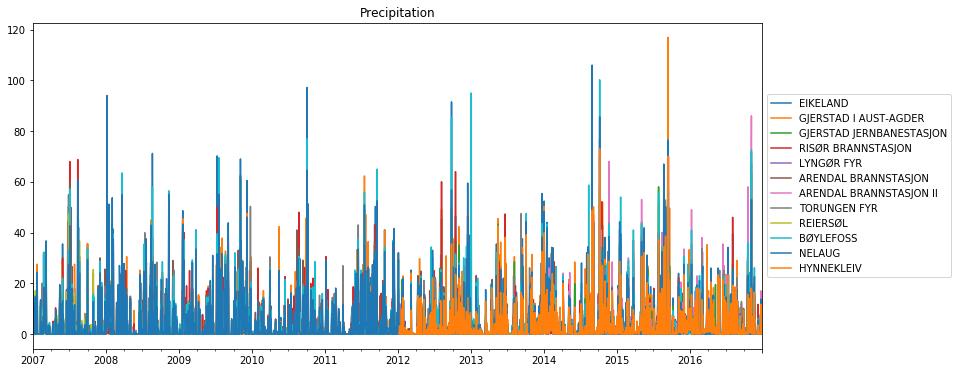

In [7]:
precipitation = pd.read_pickle('precipitation')
f = plt.figure(figsize=(15,6))
plt.title('Precipitation', color='black')
precipitation.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Plotting temperature for all stations inside buffer polygon**

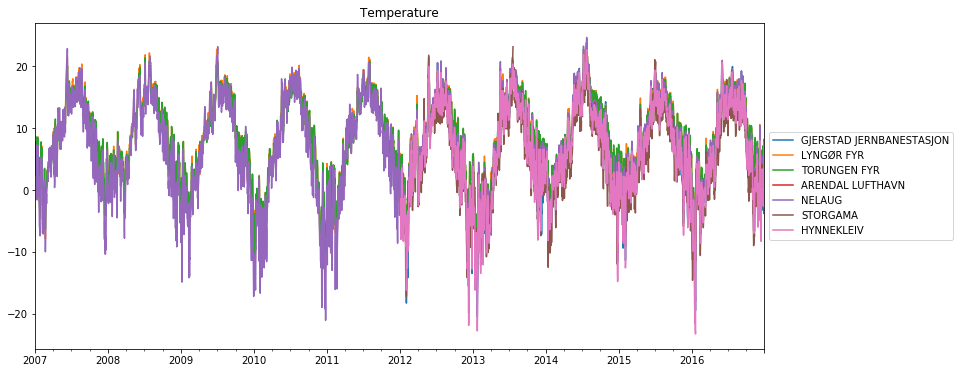

In [8]:
temperature = pd.read_pickle('temperature')
f = plt.figure(figsize=(15,6))
plt.title('Temperature', color='black')
temperature.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Getting areally weighted precipitation for the basin using Thiessen polygons**

In [9]:
#Creating directory to store shapefile
shapesDir = './shapes'
if not os.path.exists(shapesDir):
    os.makedirs(shapesDir)

#Creating a dictionary with weight for the stations with data
weightDict = {}    

#Finding out the unique combinations of precipitation stations with data for any given day
nameList = precipitation.columns.values
#print(nameList)
idList = [next(item['id'] for item in insideStations['data'] if item["name"] == x) for x in nameList]
cnt = 0;
for index, row in precipitation.notnull().drop_duplicates().iterrows() :
    #Creating csv file with geographic information and attributes for the stations that have data 
    csvFile = './shapes/dummy' + str(cnt) +  '.csv'
    cf = open(csvFile, 'w')
    writer = csv.writer(cf)
    writer.writerow(('longitude','latitude','stationId','name'))
    cnt = cnt + 1;
    currentStations = list(compress(nameList, list(row)))
    print(currentStations)
    currentIds = list(compress(idList,list(row)))
    currentCoordinates = [coordsDict[x] for x in currentStations]
    filename = os.path.join(shapesDir,'Voronoi_' + str(cnt) + '.shp')
    for i,j,k in zip(currentStations,currentIds,currentCoordinates) :
        writer.writerow((k[0],k[1],j.encode('utf-8'),i.encode('utf-8')))
    cf.close()
    #Making ESRI shapefile from csv file
    cmd = 'ogr2ogr ' + filename + ' ' + csvFile + ' -oo X_POSSIBLE_NAMES=lon* -oo Y_POSSIBLE_NAMES=lat* -oo KEEP_GEOM_COLUMNS=NO -lco ENCODING=UTF-8'
    subprocess.check_call(cmd, shell=True)
    #Computing Thiessen polygons from shapefile
    cmd = 'saga_cmd shapes_points 16 -POINTS ' + filename + ' -POLYGONS ' + filename + ' -FRAME 1'
    subprocess.check_call(cmd, shell=True)
    #Mask polygons using catchment extent
    cmd = 'saga_cmd shapes_polygons 14 -A ' + filename + ' -B /home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Storelva/Processed/Storelva_polygon/Storelva_polygon.shp -RESULT ' + filename
    subprocess.check_call(cmd, shell=True)
    #Computing area of polygons in shapefile
    cmd= 'saga_cmd shapes_polygons 2 -POLYGONS ' + filename 
    subprocess.check_call(cmd, shell=True)
    #Reading area from .dbf file
    pre,ext = os.path.splitext(filename)
    result = readArea(pre + '.dbf')
    myHash = hashlib.md5(np.array(row))
    weightDict[myHash.hexdigest()] =  result
    #print(sum(result.values()))

['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'ARENDAL BRANNSTASJON', 'TORUNGEN FYR', 'REIERSØL', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_1.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'ARENDAL BRANNSTASJON', 'REIERSØL', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_2.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'ARENDAL BRANNSTASJON', 'TORUNGEN FYR', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_3.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'ARENDAL BRANNSTASJON', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_4.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'LYNGØR FYR', 'ARENDAL BRANNSTASJON', 'TORUNGEN FYR', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_5.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'RISØR BRANNSTASJON', 'TORUNGEN FYR', 'BØYLEFOSS', 'NELAUG']
./shapes/Voronoi_6.dbf
['EIKELAND', 'GJERSTAD I AUST-AGDER', 'GJERSTAD JERNBANESTASJON', 'RISØR BRANNSTASJON', 'ARENDAL BRANNSTASJON', 'TORUNGEN FYR', 'BØYLEFOSS', '

**Actual computation of the weight precipitation**

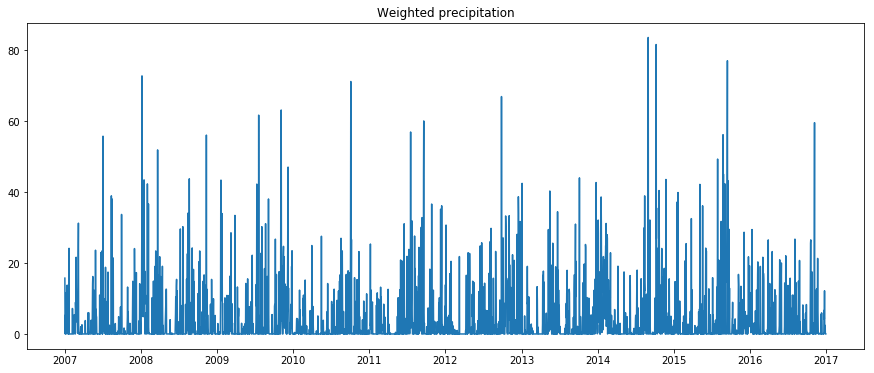

In [10]:
#Getting weighted precipitation
weighted_precip = []    
for index, row in precipitation.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    totalWeight = sum(weights.values())
    weighted_precip.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )
    

f = plt.figure(figsize=(15,6))
plt.title('Weighted precipitation', color='black')
plt.plot(precipitation.index.to_pydatetime(),weighted_precip)
plt.show()

**Generating areally weighted temperature using Thiessen polygons**

In [11]:
#Creating directory to store shapefile
shapesDir = './shapes'
if not os.path.exists(shapesDir):
    os.makedirs(shapesDir)

#Creating a dictionary with weight for the stations with data
weightDict = {}    

#Finding out the unique combinations of precipitation stations with data for any given day
nameList = temperature.columns.values
#print(nameList)
idList = [next(item['id'] for item in insideStations['data'] if item["name"] == x) for x in nameList]
cnt = 0;
for index, row in temperature.notnull().drop_duplicates().iterrows() :
    #Creating csv file with geographic information and attributes for the stations that have data 
    csvFile = './shapes/dummy' + str(cnt) +  '.csv'
    cf = open(csvFile, 'w')
    writer = csv.writer(cf)
    writer.writerow(('longitude','latitude','stationId','name'))
    cnt = cnt + 1;
    currentStations = list(compress(nameList, list(row)))
    print(currentStations)
    currentIds = list(compress(idList,list(row)))
    currentCoordinates = [coordsDict[x] for x in currentStations]
    filename = os.path.join(shapesDir,'Voronoi_' + str(cnt) + '.shp')
    for i,j,k in zip(currentStations,currentIds,currentCoordinates) :
        writer.writerow((k[0],k[1],j.encode('utf-8'),i.encode('utf-8')))
    cf.close()
    #Making ESRI shapefile from csv file
    cmd = 'ogr2ogr ' + filename + ' ' + csvFile + ' -oo X_POSSIBLE_NAMES=lon* -oo Y_POSSIBLE_NAMES=lat* -oo KEEP_GEOM_COLUMNS=NO -lco ENCODING=UTF-8'
    subprocess.check_call(cmd, shell=True)
    #Computing Thiessen polygons from shapefile
    cmd = 'saga_cmd shapes_points 16 -POINTS ' + filename + ' -POLYGONS ' + filename + ' -FRAME 1'
    subprocess.check_call(cmd, shell=True)
    #Mask polygons using catchment extent
    cmd = 'saga_cmd shapes_polygons 14 -A ' + filename + ' -B /home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Storelva/Processed/Storelva_polygon/Storelva_polygon.shp -RESULT ' + filename
    subprocess.check_call(cmd, shell=True)
    #Computing area of polygons in shapefile
    cmd= 'saga_cmd shapes_polygons 2 -POLYGONS ' + filename 
    subprocess.check_call(cmd, shell=True)
    #Reading area from .dbf file
    pre,ext = os.path.splitext(filename)
    result = readArea(pre + '.dbf')
    myHash = hashlib.md5(np.array(row))
    weightDict[myHash.hexdigest()] =  result
    #print(sum(result.values()))

['LYNGØR FYR', 'TORUNGEN FYR', 'NELAUG']
./shapes/Voronoi_1.dbf
['GJERSTAD JERNBANESTASJON', 'LYNGØR FYR', 'TORUNGEN FYR', 'NELAUG', 'HYNNEKLEIV']
./shapes/Voronoi_2.dbf
['GJERSTAD JERNBANESTASJON', 'LYNGØR FYR', 'TORUNGEN FYR', 'NELAUG', 'STORGAMA', 'HYNNEKLEIV']
./shapes/Voronoi_3.dbf
['GJERSTAD JERNBANESTASJON', 'LYNGØR FYR', 'TORUNGEN FYR', 'ARENDAL LUFTHAVN', 'NELAUG', 'STORGAMA', 'HYNNEKLEIV']
./shapes/Voronoi_4.dbf


**Actually computing the weighted temperature**

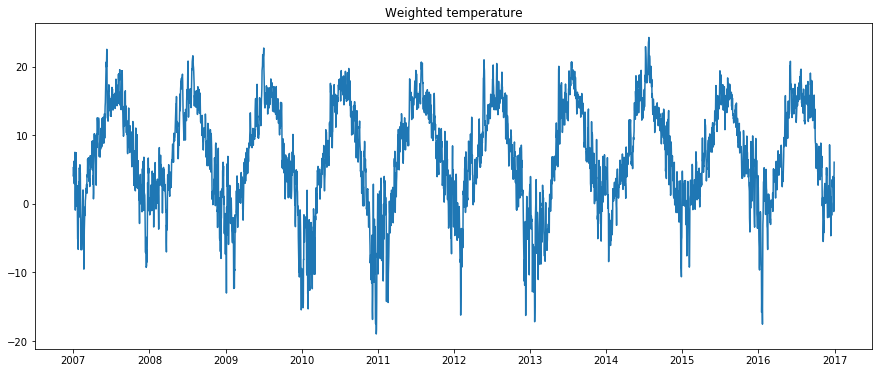

In [12]:
#Getting weighted precipitation
weighted_temp = []    
for index, row in temperature.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    totalWeight = sum(weights.values())
    weighted_temp.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )    

f = plt.figure(figsize=(15,6))
plt.title('Weighted temperature', color='black')
plt.plot(temperature.index.to_pydatetime(),weighted_temp)
plt.show()

#### Alna

The Alna basin could not be accurately delineated using the SRTM data. Instead the 10m DEM provided by [Kartverket](https://kartkatalog.geonorge.no/search) was used. This allowed to better delineate the basin albeit at the cost of slower processing of the geographic data.

**Polygon within which data are downloaded**

In [13]:
bufferPolygon = {"geometry" : "POLYGON ((10.6155136703435 59.9196896865534,10.6815690054444 60.0372740853484,\
                                         10.807001004903 60.0902525583849,10.8913740947938 60.0938074577722,\
                                         10.9744636191411 60.0790820828397,11.0765531530743 60.0419204680413,\
                                         11.1172893192172 60.0077398376955,11.1017233295938 59.9059178329121,\
                                         10.9741873524163 59.8247131318076,10.9132714509575 59.8040171753971,\
                                         10.8052217652737 59.7990497737445,10.6918414017448 59.8252561047246,\
                                         10.6258896617061 59.8706048760629,10.6155136703435 59.9196896865534))"}

**Finding out stations within the polygon**

In [14]:
data = ast.literal_eval(cipher_suite.decrypt(credentials).decode('utf-8'))

query = requests.post('https://data.met.no/auth/requestAccessToken', data=data)
data = json.loads(query.text)

headers = {}
headers['Authorization'] = 'Bearer ' + data['access_token']
headers['Accept'] = 'application/vnd.no.met.data.locations-v0+json'

queryParameters = {}
queryParameters['fields'] = 'name,geometry'
queryParameters['validtime'] = '2007-01-01/2016-12-31'
query = requests.get('https://data.met.no/sources/v0.jsonld', headers=headers, params=dict(bufferPolygon,**queryParameters)) 


insideStations = json.loads(query.text)
idString =  ','.join([i['id'] for i in insideStations['data'] if i.get('name')])
ids = [i['id'] for i in insideStations['data'] if i.get('name')]
names = [i['name'] for i in insideStations['data'] if i.get('name')]
coordinates = [i['geometry']['coordinates'] for i in insideStations['data'] if i.get('name')]
stationsDict = dict(zip(ids,names))
coordsDict = dict(zip(names,coordinates))
print(names)

['NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'ALNA', 'OSLO - NYLAND', 'OSLO - FURUSET', 'E6 FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'E6 DJUPDALEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'RV4 GJELLERÅSEN', 'OSLO - TØYEN', 'OSLO - SOFIENBERG', 'OSLO - ELVEBAKKEN', 'OSLO - HAUSMANNSGT', 'OSLO - BJØLSEN', 'OSLO - SANDAKER', 'RV4 AKER SYKEHUS', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - STUDENTERLUNDEN', 'E18 HJORTNES', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVASSHØGDA', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER', 'VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'LILLESTRØM', 'LØRENSKOG', 'KJELLER', 'KJELLER', 'SKEDSMO - HELLERUD', 'NITTEDAL - ROTNES']


**Finding out which of the above stations have mean daily discharge or temperature for a given period**

In [15]:
#Getting available time series for daily precipitation and temperature
headers['Accept']='application/vnd.no.met.data.observations.timeseries-v0+json'
queryParameters['sources'] = idString
queryParameters['elements'] = 'sum(precipitation_amount P1D),mean(air_temperature P1D)'
queryParameters.pop('fields')
queryParameters.pop('validtime')
queryParameters['referencetime'] = '2007-01-01/2016-12-31'

query = requests.get('https://data.met.no/observations/availableTimeSeries/v0.jsonld', headers=headers, params=queryParameters)
stations = json.loads(query.text)

**The precipitation and temperature are accumulated and averaged respectively at either 0600 or 1800. We use the 0600 measurements for our daily model**

In [16]:
#Finding unique identifiers in order to accumulate data within a day
for i in stations['data'] :
    myHash = hashlib.md5( str.encode( i['elementId'] + i['sourceId'] ) )
    i['hash'] = myHash.hexdigest()
    print(i['hash'], i['elementId'] + i['sourceId'])

#Going through unique hashes, keeping only values measured at 0600
for i in set([d['hash'] for d in stations['data']]) :
    stations['data'] = [x for x in stations['data'] if x['hash']!=i or (x['hash']==i and x['timeOffset']=='PT06H')]
for i in stations['data'] :
    i['sourceId'] = i['sourceId'].replace(':0','')
    

2228bff27a2768d9d9306b59224b6101 sum(precipitation_amount P1D)SN4090:0
4313a093dd6ff6f936e23088efd171a4 sum(precipitation_amount P1D)SN4110:0
9a1a6df69c2dfd820063cd1aa62f44c8 mean(air_temperature P1D)SN4200:0
9a1a6df69c2dfd820063cd1aa62f44c8 mean(air_temperature P1D)SN4200:0
66d76baef14cb1f42c5f4ab813b60d1d sum(precipitation_amount P1D)SN4260:0
66d76baef14cb1f42c5f4ab813b60d1d sum(precipitation_amount P1D)SN4260:0
340cc0a1c2feb4303b45b7412b3d554d mean(air_temperature P1D)SN4260:0
340cc0a1c2feb4303b45b7412b3d554d mean(air_temperature P1D)SN4260:0
c7ee55078d62d9ad65a4204e77f5c28e sum(precipitation_amount P1D)SN17810:0
c0aef10436c011558d2be5bd44c623ff sum(precipitation_amount P1D)SN17980:0
176c839c7329bf1fabe7728742c25652 mean(air_temperature P1D)SN17980:0
176c839c7329bf1fabe7728742c25652 mean(air_temperature P1D)SN17980:0
6ad74fbdae5cd91075a961537710d61f sum(precipitation_amount P1D)SN18020:0
a8c9096bf3a0f271937c1d476387fac9 mean(air_temperature P1D)SN18020:0
a8c9096bf3a0f271937c1d476387

**Querying data.met.no for the data**

In [17]:
#Loading all data
headers['Accept'] = 'application/vnd.no.met.data.observations-v0+json'
dataParameters = {}
dataParameters['referencetime'] =  queryParameters['referencetime']
cnt = 0
for i in stations['data'] :
    dataParameters['elements'] = i['elementId']
    dataParameters['sources'] =  i['sourceId']
    dataQuery = requests.get('https://data.met.no/observations/v0.jsonld',headers=headers, params=dataParameters)
    data = json.loads(dataQuery.text)
    values = np.array([i['observations'][0]['value'] for i in data['data']])
    timestamp = np.array([i['referenceTime'] for i in data['data']],dtype='datetime64[D]')
    columnName = i['elementId'] + "\n" +stationsDict[i['sourceId']]
    
    print(columnName)
    if cnt == 0 :
        allData = pd.DataFrame(data=values,index=timestamp,columns=[columnName])
    else :
        allData = pd.merge(allData,pd.DataFrame(data=values,index=timestamp,columns=[columnName]),left_index = True, right_index = True, how = 'outer') 
    cnt = cnt + 1

precipitation = allData.filter(regex="precipitation")
precipitation[precipitation==-1] = 0 #Need to check if -1 means no precipitation or missing measurement
temperature = allData.filter(regex="temperature")   
precipitation.rename(columns=lambda x : re.sub('^.*\n','',x),inplace=True)
temperature.rename(columns=lambda x : re.sub('^.*\n','',x),inplace=True) 

precipitation.to_pickle('precipitation')
temperature.to_pickle('temperature')   

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if sys.path[0] == '':


sum(precipitation_amount P1D)
VALLERUDÅSEN
sum(precipitation_amount P1D)
LØRENSKOG - HANEBORG
mean(air_temperature P1D)
KJELLER
sum(precipitation_amount P1D)
SKEDSMO - HELLERUD
mean(air_temperature P1D)
SKEDSMO - HELLERUD
sum(precipitation_amount P1D)
NESODDEN - TANGENÅSEN
sum(precipitation_amount P1D)
OSLO - LJABRUVEIEN
mean(air_temperature P1D)
OSLO - LJABRUVEIEN
sum(precipitation_amount P1D)
OSLO - LAMBERTSETER
mean(air_temperature P1D)
OSLO - LAMBERTSETER
sum(precipitation_amount P1D)
SKULLERUD VRA
sum(precipitation_amount P1D)
NORDSTRAND
sum(precipitation_amount P1D)
OSLO - KVÆRNERBYEN
sum(precipitation_amount P1D)
OSLO - RYEN
sum(precipitation_amount P1D)
OSLO - ØSTENSJØ
sum(precipitation_amount P1D)
OSLO - TRASOP
sum(precipitation_amount P1D)
OSLO - HØYENHALL
sum(precipitation_amount P1D)
OSLO - LØREN
sum(precipitation_amount P1D)
OSLO - HOVIN
mean(air_temperature P1D)
OSLO - HOVIN
sum(precipitation_amount P1D)
OSLO - BROBEKK
sum(precipitation_amount P1D)
OSLO - TONSENHAGEN
mean

**Plotting precipitation for all stations inside buffer polygon**

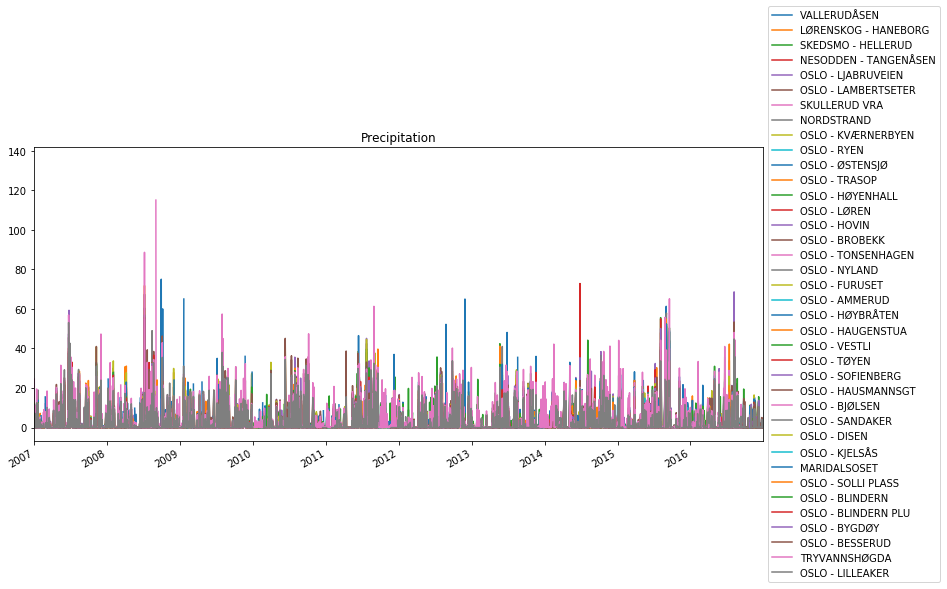

In [18]:
precipitation = pd.read_pickle('precipitation')
f = plt.figure(figsize=(15,6))
plt.title('Precipitation', color='black')
precipitation.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Plotting temperature for all stations inside buffer polygon**

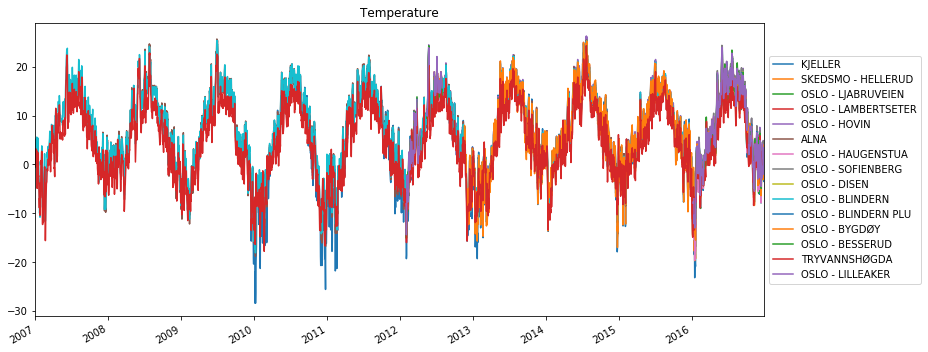

In [19]:
temperature = pd.read_pickle('temperature')
f = plt.figure(figsize=(15,6))
plt.title('Temperature', color='black')
temperature.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
f.subplots_adjust(right=0.8)
plt.show()

**Generating areally weighted precipitation using Thiessen polygons**

In [20]:
#Creating directory to store shapefile
shapesDir = './shapes'
if not os.path.exists(shapesDir):
    os.makedirs(shapesDir)

#Creating a dictionary with weight for the stations with data
weightDict = {}    

#Finding out the unique combinations of precipitation stations with data for any given day
nameList = precipitation.columns.values
#print(nameList)
idList = [next(item['id'] for item in insideStations['data'] if item["name"] == x) for x in nameList]
cnt = 0;
for index, row in precipitation.notnull().drop_duplicates().iterrows() :
    #Creating csv file with geographic information and attributes for the stations that have data 
    csvFile = './shapes/dummy' + str(cnt) +  '.csv'
    cf = open(csvFile, 'w')
    writer = csv.writer(cf)
    writer.writerow(('longitude','latitude','stationId','name'))
    cnt = cnt + 1;
    currentStations = list(compress(nameList, list(row)))
    print(currentStations)
    currentIds = list(compress(idList,list(row)))
    currentCoordinates = [coordsDict[x] for x in currentStations]
    filename = os.path.join(shapesDir,'Voronoi_' + str(cnt) + '.shp')
    for i,j,k in zip(currentStations,currentIds,currentCoordinates) :
        writer.writerow((k[0],k[1],j.encode('utf-8'),i.encode('utf-8')))
    cf.close()
    #Making ESRI shapefile from csv file
    cmd = 'ogr2ogr dummy.shp ' + csvFile + ' -oo X_POSSIBLE_NAMES=lon* -oo Y_POSSIBLE_NAMES=lat* -oo KEEP_GEOM_COLUMNS=NO -lco ENCODING=UTF-8 -overwrite' # -a_srs EPSG:32632'
    subprocess.check_call(cmd, shell=True)
    #Different projections between the Alna DEM and the one use for Storelva
    cmd = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:32632 -s_srs EPSG:4326 ' + filename + ' dummy.shp'
    subprocess.check_call(cmd, shell=True)    
    #Computing Thiessen polygons from shapefile
    cmd = 'saga_cmd shapes_points 16 -POINTS ' + filename + ' -POLYGONS ' + filename + ' -FRAME 5000'
    subprocess.check_call(cmd, shell=True)
    #Mask polygons using catchment extent
    cmd = 'saga_cmd shapes_polygons 14 -A ' + filename + ' -B /home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Alna/Processed/Alna_basin.shp -RESULT ' + filename
    subprocess.check_call(cmd, shell=True)
    #Computing area of polygons in shapefile
    cmd= 'saga_cmd shapes_polygons 2 -POLYGONS ' + filename 
    subprocess.check_call(cmd, shell=True)
    #Reading area from .dbf file
    pre,ext = os.path.splitext(filename)
    result = readArea(pre + '.dbf')
    myHash = hashlib.md5(np.array(row))
    weightDict[myHash.hexdigest()] =  result

['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_1.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_2.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_3.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - B

./shapes/Voronoi_32.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_33.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_34.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_35.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN 

./shapes/Voronoi_64.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_65.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_66.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_67.dbf
['OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_68.dbf
['OSLO - LAMBERTSETER', 'SKULLERUD VRA', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNS

./shapes/Voronoi_100.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA']
./shapes/Voronoi_101.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA']
./shapes/Voronoi_102.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'TRYVANNSHØGDA']
./shapes/Voronoi_103.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BESSERUD', 'TRYVANNSHØGDA']
./shapes/Voronoi_104.dbf
['OSLO - LJABRUVEIEN', 'OSLO

./shapes/Voronoi_139.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_140.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA']
./shapes/Voronoi_141.dbf
['OSLO - LJABRUVEIEN', 'NORDSTRAND', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_142.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'TRYVANNSHØGDA', 'OSL

./shapes/Voronoi_169.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HOVIN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_170.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HOVIN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_171.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OS

./shapes/Voronoi_188.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - HAUSMANNSGT', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_189.dbf
['SKEDSMO - HELLERUD', 'NORDSTRAND', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'TRYVANNSHØGDA']
./shapes/Voronoi_190.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENH

./shapes/Voronoi_209.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - TØYEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_210.dbf
['OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - TØYEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_211.dbf
['OSLO - LJABRUVEIE

./shapes/Voronoi_226.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_227.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDE

./shapes/Voronoi_242.dbf
['SKEDSMO - HELLERUD', 'NORDSTRAND', 'OSLO - VESTLI', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'TRYVANNSHØGDA']
./shapes/Voronoi_243.dbf
['VALLERUDÅSEN', 'SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_244.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_245.

./shapes/Voronoi_258.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - SOFIENBERG', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_259.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅ

./shapes/Voronoi_272.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_273.dbf
['SKEDSMO - HELLERUD', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - VESTLI', 'OSLO - TØYEN', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'TRYVANNSHØGDA']
./shapes/Voronoi_274.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSL

./shapes/Voronoi_289.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_290.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - VESTLI', 'OSLO - TØYEN

./shapes/Voronoi_303.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - SOFIENBERG', 'OSLO - BJØLSEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_304.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OS

./shapes/Voronoi_316.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - SOFIENBERG', 'OSLO - BJØLSEN', 'OSLO - SANDAKER', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_317.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OS

./shapes/Voronoi_331.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - SANDAKER', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'TRYVANNSHØGDA']
./shapes/Voronoi_332.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND

./shapes/Voronoi_344.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - TØYEN', 'OSLO - SOFIENBERG', 'OSLO - BJØLSEN', 'OSLO - SANDAKER', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_345.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAG

./shapes/Voronoi_357.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - TØYEN', 'OSLO - BJØLSEN', 'OSLO - SANDAKER', 'OSLO - DISEN', 'OSLO - KJELSÅS', 'MARIDALSOSET', 'OSLO - SOLLI PLASS', 'OSLO - BLINDERN', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'OSLO - LILLEAKER']
./shapes/Voronoi_358.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - ØSTENSJØ', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OS

./shapes/Voronoi_375.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - VESTLI', 'OSLO - SOFIENBERG', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - LILLEAKER']
./shapes/Voronoi_376.dbf
['SKEDSMO - HELLERUD', 'OSLO - LJABRUVEIEN', 'NORDSTRAND', 'OSLO - HOVIN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - SOFIENBERG', 'OSLO - DISEN', 'MARIDALSOSET', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - LILLEAKER']
./shapes/Voronoi_377.dbf
['VALLERUDÅSEN', 'LØRENSKOG - HANEBORG', 'SKEDSMO - HELLERUD', 'NESODDEN - TANGENÅSEN', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'NORDSTRAND', 'OSLO - KVÆRNERBYEN', 'OSLO - RYEN', 'OSLO - TRASOP', 'OSLO - HØYENHALL', 'OSLO - LØREN', 'OSLO - HOVIN', 'OSLO - BROBEKK', 'OSLO - TONSENHAGEN', 'OSLO - NYLAND', 'OSLO - FURUSET', 'OSLO - AMMERUD', 'OSLO - HØYBRÅTEN', 'OSLO - HAUGENSTUA', 'OSLO - VESTLI', 'OSLO - SOFIENBERG', 'OSLO - 

**Actually computing and plotting weighted precipitation**

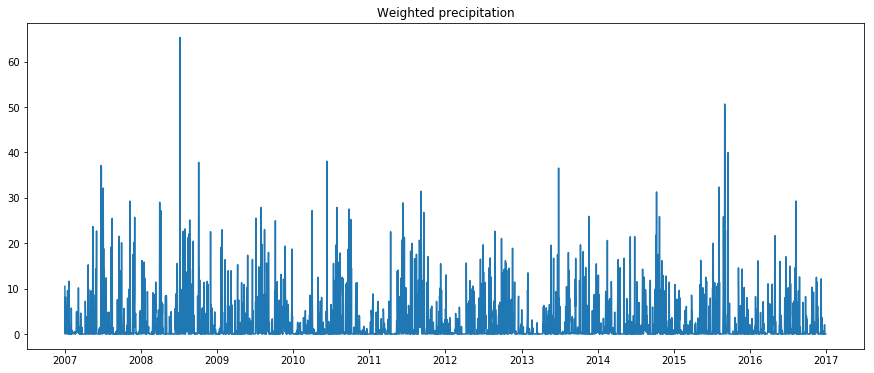

In [21]:
#Getting weighted precipitation
totalWeight = sum(list(weightDict[list(weightDict.keys())[0]].values()))
weighted_precip = []    
for index, row in precipitation.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    weighted_precip.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )
    

f = plt.figure(figsize=(15,6))
plt.title('Weighted precipitation', color='black')
plt.plot(precipitation.index.to_pydatetime(),weighted_precip)
plt.show()

**Generating areally weighted temperature using Thiessen polygons**

In [22]:
#Creating directory to store shapefile
shapesDir = './shapes'
if not os.path.exists(shapesDir):
    os.makedirs(shapesDir)

#Creating a dictionary with weight for the stations with data
weightDict = {}    

#Finding out the unique combinations of precipitation stations with data for any given day
nameList = temperature.columns.values
#print(nameList)
idList = [next(item['id'] for item in insideStations['data'] if item["name"] == x) for x in nameList]
cnt = 0;
for index, row in temperature.notnull().drop_duplicates().iterrows() :
    #Creating csv file with geographic information and attributes for the stations that have data 
    csvFile = './shapes/dummy' + str(cnt) +  '.csv'
    cf = open(csvFile, 'w') 
    writer = csv.writer(cf)
    writer.writerow(('longitude','latitude','stationId','name'))
    cnt = cnt + 1;
    currentStations = list(compress(nameList, list(row)))
    print(currentStations)
    currentIds = list(compress(idList,list(row)))
    currentCoordinates = [coordsDict[x] for x in currentStations]
    filename = os.path.join(shapesDir,'Voronoi_' + str(cnt) + '.shp')
    for i,j,k in zip(currentStations,currentIds,currentCoordinates) :
        writer.writerow((k[0],k[1],j.encode('utf-8'),i.encode('utf-8')))
    #Increasing extent if less than three stations are available
    if (len(currentStations) < 3) :
        writer.writerow((4.0,54.0,'dummy'.encode('utf-8'),'dummy'.encode('utf-8')))
        writer.writerow((4.0,64.0,'dummy'.encode('utf-8'),'dummy'.encode('utf-8')))
        writer.writerow((14.0,54.0,'dummy'.encode('utf-8'),'dummy'.encode('utf-8')))
        writer.writerow((14.0,64.0,'dummy'.encode('utf-8'),'dummy'.encode('utf-8')))
    cf.close()
    #Making ESRI shapefile from csv file
    cmd = 'ogr2ogr dummy.shp ' + csvFile + ' -oo X_POSSIBLE_NAMES=lon* -oo Y_POSSIBLE_NAMES=lat* -oo KEEP_GEOM_COLUMNS=NO -lco ENCODING=UTF-8 -overwrite' # -a_srs EPSG:32632'
    subprocess.check_call(cmd, shell=True)
    #Different projections between the Alna DEM and the one use for Storelva
    cmd = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:32632 -s_srs EPSG:4326 ' + filename + ' dummy.shp'
    subprocess.check_call(cmd, shell=True)    
    #Computing Thiessen polygons from shapefile
    cmd = 'saga_cmd shapes_points 16 -POINTS ' + filename + ' -POLYGONS ' + filename + ' -FRAME 25000'
    subprocess.check_call(cmd, shell=True)
    #Mask polygons using catchment extent
    cmd = 'saga_cmd shapes_polygons 14 -A ' + filename + ' -B /home/jose-luis/Dropbox/NIVA/Modelling_HBV_Oyvind/SRTM_data/Alna/Processed/Alna_basin.shp -RESULT ' + filename
    subprocess.check_call(cmd, shell=True)
    #Computing area of polygons in shapefile
    cmd= 'saga_cmd shapes_polygons 2 -POLYGONS ' + filename 
    subprocess.check_call(cmd, shell=True)
    #Reading area from .dbf file
    pre,ext = os.path.splitext(filename)
    result = readArea(pre + '.dbf')
    myHash = hashlib.md5(np.array(row))
    weightDict[myHash.hexdigest()] =  result

['OSLO - BLINDERN', 'TRYVANNSHØGDA']
./shapes/Voronoi_1.dbf
['ALNA', 'OSLO - BLINDERN', 'TRYVANNSHØGDA']
./shapes/Voronoi_2.dbf
['KJELLER', 'ALNA', 'OSLO - BLINDERN', 'TRYVANNSHØGDA']
./shapes/Voronoi_3.dbf
['KJELLER', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'OSLO - HOVIN', 'ALNA', 'OSLO - HAUGENSTUA', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_4.dbf
['KJELLER', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'ALNA', 'OSLO - HAUGENSTUA', 'OSLO - DISEN', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO - LILLEAKER']
./shapes/Voronoi_5.dbf
['KJELLER', 'OSLO - HOVIN', 'ALNA', 'OSLO - BLINDERN', 'TRYVANNSHØGDA']
./shapes/Voronoi_6.dbf
['KJELLER', 'OSLO - LJABRUVEIEN', 'OSLO - LAMBERTSETER', 'OSLO - HOVIN', 'ALNA', 'OSLO - HAUGENSTUA', 'OSLO - BLINDERN', 'OSLO - BLINDERN PLU', 'OSLO - BYGDØY', 'OSLO - BESSERUD', 'TRYVANNSHØGDA', 'OSLO

**Actually computing and plotting weighted temperature**

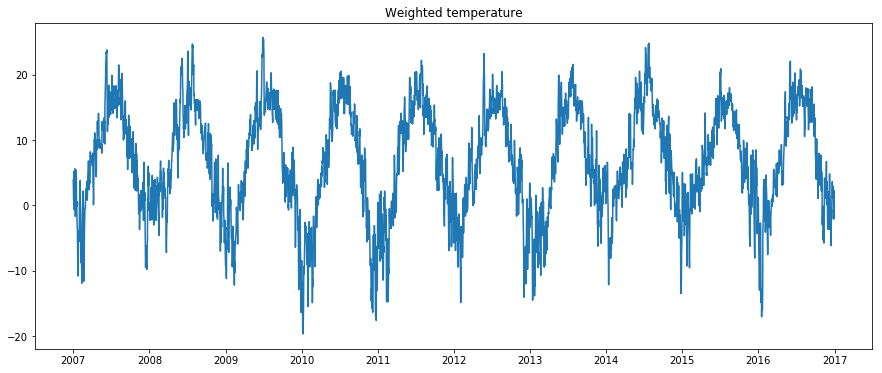

In [23]:
#Getting weighted precipitation
totalWeight = sum(list(weightDict[list(weightDict.keys())[0]].values()))
weighted_temp = []    
for index, row in temperature.iterrows() :
    key = row.notnull();
    myHash = hashlib.md5(np.array(row.notnull()))
    weights = weightDict[myHash.hexdigest()]
    weighted_temp.append( sum(row[list(weights.keys())] * list(weights.values()) / totalWeight) )
    

f = plt.figure(figsize=(15,6))
plt.title('Weighted temperature', color='black')
plt.plot(temperature.index.to_pydatetime(),weighted_temp)
plt.show()